# 🥱 工安監控管理 RAG

❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).

#利用知識圖譜為LangChain應用提供動力

RAG（檢索增強生成）應用在當前的AI領域中炙手可熱。許多公司都在開發自家的文件問答機器人或類似的智慧助理。這些應用通常有個共同點：它們的知識來源主要是非結構化文字，這些文字經過切割處理和嵌入後儲存。然而，實務上並非所有的資訊都是以非結構化文字的形式存在的。

假設您想要打造一個聊天機器人，用來回答有關工地安全狀況、事故預防和風險評估等問題。工地的一些基本資訊，如地點描述、施工計畫等，可能是以非結構化文字形式存在的，這與傳統的RAG工作流程相符。但是，您要如何處理那些即時產生的異常事件資料，好讓聊天機器人能夠檢索最新的安全資訊呢？

一種做法是將每日的異常事件紀錄轉換為結構化的文字描述，讓大型語言模型（LLM）能夠理解。但是，這種方法可能會喪失資料間的關聯性，也難以進行複雜的分析。那麼，有沒有更好的解決方案呢？這就是知識圖譜大顯身手的時候了。知識圖譜能夠在同一個資料庫中同時儲存結構化和非結構化的資訊。

透過使用知識圖譜，我們可以將工地位置、事故類型、相關人員、監控設備和異常事件等多面向資訊串連起來，形成一個完整的資料網絡。這不僅使得聊天機器人能夠回答更複雜的問題，如「為什麼某類事故在特定地點頻繁發生」，還能支援更深入的安全分析，像是辨識潛在的風險模式或評估預防措施的成效。

#工地安全監控知識圖譜：革新安全管理的RAG應用

![放入 Neo4j 截圖](https://i.imgur.com/omexatY.png)

節點與關係是描述知識圖譜中資料的基本元素。一般來說，節點用來表示實體或概念，如人員、地點和事件。在我們的工地安全監控圖譜中，節點描述了工人、監控人員、事故地點、事故類型及異常事件等。而關係則定義了這些實體之間的連結，例如事故發生的地點、異常事件是由哪一支攝影機記錄，或是由誰來處理等。

節點與關係都可以擁有以鍵值對形式儲存的屬性值。舉例來說，事故地點節點有名稱和地址兩個屬性，而事故節點則更為複雜，包含了ID、日期及嚴重程度等屬性。特別值得一提的是，我們可以在異常事件節點中加入文本嵌入值作為節點屬性。這樣一來，我們便可以對異常事件的描述進行向量相似度搜尋，彷彿這些事件被儲存在向量資料庫中。因此，知識圖譜讓我們能夠同時儲存與檢索結構化和非結構化資訊，為RAG應用提供強大的支援。

這種結構不僅提供了豐富的上下文資訊，還支持複雜的推理。例如，我們可以輕鬆追蹤特定類型的事故在不同地點的發生頻率，或分析某位監控人員處理異常事件的效率。這大大提升了RAG系統的分析深度，使其能夠回答更深入的問題，如「為什麼某類事故頻繁發生」或「如何有效預防特定類型的異常事件」。

本篇文章中，我將帶您逐步了解如何使用LangChain實現基於知識圖譜的RAG應用，以支持您的工地安全管理團隊。這個應用將幫助您更有效地分析安全數據，預測潛在風險，並制定更精確的預防措施。完整的代碼可在GitHub上獲取。

通過這種方式，我們不僅可以提高安全管理的效率，還可以為決策者提供更可靠、更具洞察力的信息支持，最終提升整體的工地安全水平。

#環境安裝

In [1]:
%%capture
%pip install --quiet neo4j openai langchain tiktoken langchain-openai langchainhub langchain-community langchain-experimental chromdb graphdatascience datasets tiktoken retry yfiles_jupyter_graphs

接下來，設置 OpenAI API 密鑰和 Neo4j 環境變量：

In [2]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

## 建置 Neo4j 環境

In [4]:
from langchain_community.graphs import Neo4jGraph

from langchain_community.graphs import Neo4jGraph

os.environ["NEO4J_URI"] = "bolt://52.90.86.117"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "cross-dispatchers-swing"
os.environ["NEO4J_DATABASE"] = "neo4j"

graph = Neo4jGraph()

# 資料集

知識圖非常擅長連接來自多個資料來源的資訊。

![工安事件來源](https://i.imgur.com/8yUvHcJ.png)

以下程式碼將範例圖匯入到 Neo4j 中。

In [5]:
import requests
import_url = "https://gist.githubusercontent.com/Heng-xiu/a6417c4c34c80147cfbccdaa52925a55/raw/1126ea63fe28838d20af23441c4900ec768cfeb5/construction_site_safety.json"
import_query = requests.get(import_url).json()['query']
graph.query(
    import_query
)

[]

可以使用 yfiles 直接在 Colab 上查看

> 這個展示用炫砲性質居多

In [6]:
from yfiles_jupyter_graphs import GraphWidget
from neo4j import GraphDatabase

from google.colab import output
output.enable_custom_widget_manager()

default_cypher = "MATCH (n) RETURN n LIMIT 50"

def showGraph(cypher: str = default_cypher):
    # create a neo4j session to run queries
    driver = GraphDatabase.driver(
        uri = os.environ["NEO4J_URI"],
        auth = (os.environ["NEO4J_USERNAME"],
                os.environ["NEO4J_PASSWORD"]))
    session = driver.session()
    widget = GraphWidget(graph = session.run(cypher).graph())
    widget.node_label_mapping = 'id'
    #display(widget)
    return widget

showGraph()

GraphWidget(layout=Layout(height='800px', width='100%'))

# 查詢 GRaph 的兩種方式

1. Cypher 形式，GraphCypherQAChain
  - 直接將自然語言轉換成為 Cypher 進行檢索
2. semantic 形式，VectorSearch
  - 將自然語言轉成向量之後，在 Neo4j 資料庫中查詢

## 方法一、向量檢索

我們將首先實現向量索引搜索，透過名稱和描述查找相關任務。如果您不熟悉向量相似性搜索，讓我快速回顧一下。關鍵思想是根據每個任務的描述和名稱計算文字嵌入值。然後，在查詢時，使用餘弦距離等相似性度量找到與使用者輸入最相似的任務。

In [7]:
import os
from langchain_community.vectorstores.neo4j_vector import Neo4jVector
from langchain_openai import OpenAIEmbeddings


''' Create an safety_incidets vector and Instantiate Neo4j vector from graph'''
safety_incidents_vector_index = Neo4jVector.from_existing_graph(
    OpenAIEmbeddings(),
    index_name='safety_incidents',
    node_label="Incident",
    text_node_properties=['id', 'date', 'severity', 'description'],
    embedding_node_property='embedding',
)

在此範例中，我們為 from_existing_graph 方法使用了以下特定於圖的參數。
1. `index_name`：我們將其改為'safety_incidents'，這更好地反映了我們的用例。
2. `node_label`：我們使用"Incident"作為標籤，因為我們主要關注的是事故節點。
3. `text_node_properties`：我們包括了事故的id、日期、嚴重程度和描述。這些屬性提供了關於每個事故的關鍵信息，可以用來生成有意義的向量。
4. `embedding_node_property`：我們保留'embedding'作為存儲嵌入向量的屬性名。

現在向量索引已經啟動，我們可以像LangChain中的任何其他向量索引一樣使用它。



In [8]:
response = safety_incidents_vector_index.similarity_search(
    "最近有沒有工人中暑的事故？"
)
print(response[0].page_content)


id: INC007
date: 2024-09-15
severity: 低
description: 工人中暑


每次調用similarity_search時，它會返回一個列表，包含最相似的文檔（在我們的情況下是事故記錄）。response[0]代表最相似的結果，而.page_content會顯示該結果的內容。

如果您想獲取多個相似的結果，可以指定k參數：

In [9]:
response = safety_incidents_vector_index.similarity_search(
    "有發生電氣安全事故嗎？",
    k=3  # 返回前3個最相似的結果
)

for i, doc in enumerate(response):
    print(f"結果 {i+1}:")
    print(doc.page_content)
    print("---")

結果 1:

id: INC018
date: 2024-11-10
severity: 中
description: 工人吸入有害氣體
---
結果 2:

id: INC013
date: 2024-10-15
severity: 高
description: 工人觸電重傷
---
結果 3:

id: INC009
date: 2024-09-25
severity: 高
description: 大型機械操作不當造成嚴重事故
---


結合多個條件的複雜查詢：

In [10]:
response = safety_incidents_vector_index.similarity_search(
    "有沒有工人因為沒戴安全帽受傷的事故？最嚴重的是哪次？",
    filter={
        "$or": [
            {"description": {"$like": "安全帽"}},
            {"description": {"$like": "頭部防護"}},
            {"severity": {"$in": ["高"]}}
        ],

    },
    k=3
)
for i, doc in enumerate(response):
    print(f"事故 {i+1}:")
    print(doc.page_content)
    print("---")

事故 1:

id: INC013
date: 2024-10-15
severity: 高
description: 工人觸電重傷
---
事故 2:

id: INC001
date: 2024-08-15
severity: 高
description: 工人從鷹架上墜落
---
事故 3:

id: INC009
date: 2024-09-25
severity: 高
description: 大型機械操作不當造成嚴重事故
---


您可以觀察到，我們使用 text_node_properties 參數中定義的屬性建立了映射或類似字典的字串的回應。

現在，我們可以透過將向量索引包裝到 RetrievalQA 模組中來輕鬆建立聊天機器人回應。

In [11]:
from langchain.chains import RetrievalQA
from langchain_openai import ChatOpenAI

vector_qa = RetrievalQA.from_chain_type(
    llm=ChatOpenAI(), chain_type="stuff", retriever=safety_incidents_vector_index.as_retriever())

In [12]:
vector_qa.invoke(
    {"query": "最近有沒有工人中暑的事故？"}
)

{'query': '最近有沒有工人中暑的事故？',
 'result': '是的，最近發生了一起工人中暑的事故，事件編號是INC007，發生在2024年9月15日。'}

## 方法二、Graph Cypher search

Cypher 是一種結構化查詢語言，旨在與圖形資料庫交互，並提供匹配模式和關係的可視化方式。它依賴以下 ascii-art 類型的語法：

```bash
(:Person {name:"Tomaz"})-[:LIVES_IN]->(:Country {name:"Slovenia"})
```

LangChain 的巧妙之處在於它提供了 GraphCypherQAChain，它可以為您產生 Cypher 查詢，因此您無需學習 Cypher 語法即可從 Neo4j 等圖形資料庫中檢索資訊。以下程式碼將刷新圖模式並實例化 Cypher 鏈。

In [13]:
from langchain.chains import GraphCypherQAChain
from langchain_openai import ChatOpenAI

#當有更新資料庫時，就需要使用
graph.refresh_schema()

cypher_chain = GraphCypherQAChain.from_llm(
    cypher_llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini'),
    qa_llm = ChatOpenAI(temperature=0),
    graph=graph,
    verbose=True,
    validate_cypher= True,
    return_direct = True,
)

In [15]:
cypher_chain.invoke(
    {"query": "有多少起高空墜落發生?"}
)



> Entering new GraphCypherQAChain chain...
Generated Cypher:

MATCH (i:Incident)-[:CATEGORIZED_AS]->(it:IncidentType {name: '高空墜落'})
RETURN COUNT(i) AS 高空墜落事件數量


> Finished chain.


{'query': '有多少起高空墜落發生?', 'result': [{'高空墜落事件數量': 0}]}

顯然地透過強大的閉源模型 Gpt4o-mini 也是會產生錯誤的內容，原因是生成的Cypher查詢在尋找名為"高空墜落"的IncidentType，但在我們的資料中，我們使用的是"墜落"而不是"高空墜落"。

顯然的模型缺乏語義理解，沒有理解"高空墜落"和"墜落"在這個上下文中是等同的。

### 提高 GraphCypherQA 生成 Cypher 機率

這邊我們有幾個策略，可以來修正這個問題

參考自
1. [LangChain/Prompting strategies](https://python.langchain.com/v0.1/docs/use_cases/graph/prompting/)
2. [LangChain Cypher Search: Tips & Tricks
](https://neo4j.com/developer-blog/langchain-cypher-search-tips-tricks/)

#### 策略ㄧ、直接 Fewshot 在 Prompt 當中

In [16]:
from langchain.prompts.prompt import PromptTemplate

CYPHER_GENERATION_TEMPLATE = """
任務：生成Cypher語句以查詢圖形數據庫。
指示：
僅使用提供的關係類型和屬性。
不要使用未提供的任何其他關係類型或屬性。
模式：
{schema}
Cypher範例：
# 有多少起高空墜落發生？
MATCH (i:Incident)-[:CATEGORIZED_AS]->(it:IncidentType {{name: '墜落'}})
RETURN count(i) AS 墜落事故數量

# 哪些工地發生過嚴重程度高的事故？
MATCH (i:Incident {{severity: '高'}})-[:OCCURRED_AT]->(l:IncidentLocation)
RETURN DISTINCT l.name AS 工地名稱

注意：不要在您的回答中包含任何解釋或道歉。
不要回答任何可能詢問除了構建Cypher語句以外的任何問題。
不要包含生成的Cypher語句以外的任何文本。

問題是：
{question}"""

CYPHER_GENERATION_PROMPT = PromptTemplate(
    input_variables=["schema", "question"], template=CYPHER_GENERATION_TEMPLATE
)

In [17]:
chain_language_example = GraphCypherQAChain.from_llm(
    ChatOpenAI(temperature=0),
    graph=graph,
    verbose=True,
    cypher_prompt=CYPHER_GENERATION_PROMPT
)

chain_language_example.run("""有多少起高空墜落發生?""")

<ipython-input-17-1c4e7d8823e9>:6: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use invoke instead.
  chain_language_example.run("""有多少起高空墜落發生?""")




> Entering new GraphCypherQAChain chain...
Generated Cypher:
MATCH (i:Incident)-[:CATEGORIZED_AS]->(it:IncidentType {name: '墜落'})
WHERE i.severity = '高'
RETURN count(i) AS 墜落事故數量
Full Context:
[{'墜落事故數量': 1}]

> Finished chain.


'有1起高空墜落事故發生。'

#### 策略二、使用 Prompt Selector

##### 實作 Prompt_examples

In [68]:
examples = [
  {
    "question": "找出所有高嚴重性的事故及其發生地點",
    "query": "MATCH (i:Incident)-[:OCCURRED_AT]->(l:IncidentLocation) WHERE i.severity = '高' RETURN i.id, i.description, l.name"
  },
  {
    "question": "查詢特定工人參與的所有事故",
    "query": "MATCH (w:InvolvedPerson)-[:INVOLVED_IN]->(i:Incident) WHERE w.name = '張志明' RETURN i.id, i.date, i.description"
  },
  {
    "question": "列出所有發生在高雄港的事故及其類型",
    "query": "MATCH (i:Incident)-[:OCCURRED_AT]->(l:IncidentLocation) WHERE l.name = '高雄港' MATCH (i)-[:CATEGORIZED_AS]->(t:IncidentType) RETURN i.id, i.description, t.name"
  },
  {
    "question": "找出所有由特定監控人員處理的異常事件及相關事故",
    "query": "MATCH (m:Monitor)-[:HANDLED_BY]-(a:AnomalyEvent)-[:RELATED_TO]->(i:Incident) WHERE m.name = '黃小芬' RETURN a.id, a.type, i.id, i.description"
  },
  {
    "question": "查詢特定區域內的所有監控攝像頭及其狀態",
    "query": "MATCH (c:SurveillanceCamera)-[:MONITORS]->(a:SiteArea) WHERE a.name = '港口建設區' RETURN c.id, c.status, c.type"
  },
  {
    "question": "列出所有墜落事故及涉及的工人和地點",
    "query": "MATCH (i:Incident)-[:CATEGORIZED_AS]->(t:IncidentType {name: '墜落'}) MATCH (i)-[:OCCURRED_AT]->(l:IncidentLocation) MATCH (w:InvolvedPerson)-[:INVOLVED_IN]->(i) RETURN i.id, i.description, w.name, l.name"
  },
  {
    "question": "找出過去一個月內發生的所有事故",
    "query": "MATCH (i:Incident) WHERE date(i.date) > date() - duration('P1M') RETURN i.id, i.date, i.description ORDER BY i.date DESC"
  },
  {
    "question": "查詢所有高風險區域及其最近發生的事故",
    "query": "MATCH (a:SiteArea {risk_level: '高'})<-[:MONITORS]-(c:SurveillanceCamera)<-[:RECORDED_BY]-(ano:AnomalyEvent)-[:RELATED_TO]->(i:Incident) RETURN a.name, i.id, i.date, i.description ORDER BY i.date DESC LIMIT 1"
  },
  {
    "question": "列出所有未解決的異常事件及其相關的監控攝像頭",
    "query": "MATCH (a:AnomalyEvent)-[:RECORDED_BY]->(c:SurveillanceCamera) WHERE NOT EXISTS((a)-[:HANDLED_BY]->()) RETURN a.id, a.type, a.timestamp, c.id"
  },
  {
    "question": "找出處理最多異常事件的前5名監控人員",
    "query": "MATCH (m:Monitor)<-[:HANDLED_BY]-(a:AnomalyEvent) WITH m, COUNT(a) AS handled_count RETURN m.name, m.shift, handled_count ORDER BY handled_count DESC LIMIT 5"
  },
  {
    "question": "查詢所有設備故障類型的事故及其發生地點",
    "query": "MATCH (i:Incident)-[:CATEGORIZED_AS]->(t:IncidentType {name: '設備故障'}) MATCH (i)-[:OCCURRED_AT]->(l:IncidentLocation) RETURN i.id, i.description, l.name"
  },
  {
    "question": "列出所有工作經驗超過5年的工人及其參與的事故數量",
    "query": "MATCH (w:InvolvedPerson)-[:INVOLVED_IN]->(i:Incident) WHERE toInteger(substring(w.experience, 0, size(w.experience) - 1)) > 5 WITH w, COUNT(i) AS incident_count RETURN w.name, w.role, w.experience, incident_count ORDER BY incident_count DESC"
  },
  {
    "question": "找出所有發生在地下或隧道區域的事故",
    "query": "MATCH (i:Incident)-[:OCCURRED_AT]->(l:IncidentLocation) WHERE l.name CONTAINS '地下' OR l.name CONTAINS '隧道' RETURN i.id, i.description, l.name"
  },
  {
    "question": "查詢所有涉及化學品洩漏的事故及處理這些事故的監控人員",
    "query": "MATCH (i:Incident)-[:CATEGORIZED_AS]->(t:IncidentType {name: '化學品洩漏'}) MATCH (i)<-[:RELATED_TO]-(a:AnomalyEvent)-[:HANDLED_BY]->(m:Monitor) RETURN i.id, i.description, m.name"
  },
  {
    "question": "列出所有大型工地區域及其最近的安全事故",
    "query": "MATCH (a:SiteArea {size: '大型'})<-[:MONITORS]-(c:SurveillanceCamera)<-[:RECORDED_BY]-(ano:AnomalyEvent)-[:RELATED_TO]->(i:Incident) RETURN a.name, i.id, i.date, i.description ORDER BY i.date DESC LIMIT 1"
  },
  {
    "question": "找出所有夜班監控人員處理的異常事件類型及數量",
    "query": "MATCH (m:Monitor {shift: '夜班'})<-[:HANDLED_BY]-(a:AnomalyEvent) WITH m, a.type AS anomaly_type, COUNT(a) AS anomaly_count RETURN m.name, anomaly_type, anomaly_count ORDER BY m.name, anomaly_count DESC"
  },
  {
    "question": "查詢所有需要維修的監控攝像頭及其監控的區域",
    "query": "MATCH (c:SurveillanceCamera {status: '維修中'})-[:MONITORS]->(a:SiteArea) RETURN c.id, c.type, a.name, a.risk_level"
  },
  {
    "question": "列出所有發生過高嚴重性事故的工地區域及事故次數",
    "query": "MATCH (i:Incident {severity: '高'})-[:OCCURRED_AT]->(l:IncidentLocation) WITH l, COUNT(i) AS high_severity_count RETURN l.name, high_severity_count ORDER BY high_severity_count DESC"
  },
  {
    "question": "找出所有參與過多次（超過3次）事故的工人",
    "query": "MATCH (w:InvolvedPerson)-[:INVOLVED_IN]->(i:Incident) WITH w, COUNT(i) AS incident_count WHERE incident_count > 3 RETURN w.name, w.role, incident_count ORDER BY incident_count DESC"
  },
  {
    "question": "查詢所有球型攝像頭記錄的異常事件類型及數量",
    "query": "MATCH (c:SurveillanceCamera {type: '球型'})<-[:RECORDED_BY]-(a:AnomalyEvent) WITH a.type AS anomaly_type, COUNT(a) AS anomaly_count RETURN anomaly_type, anomaly_count ORDER BY anomaly_count DESC"
  },
  {
    "question": "列出所有高風險區域中未處理的異常事件",
    "query": "MATCH (a:SiteArea {risk_level: '高'})<-[:MONITORS]-(c:SurveillanceCamera)<-[:RECORDED_BY]-(ano:AnomalyEvent) WHERE NOT EXISTS((ano)-[:HANDLED_BY]->()) RETURN a.name, ano.id, ano.type, ano.timestamp"
  },
  {
    "question": "找出所有涉及觸電的事故及相關工人的工作經驗",
    "query": "MATCH (i:Incident)-[:CATEGORIZED_AS]->(t:IncidentType {name: '觸電'}) MATCH (w:InvolvedPerson)-[:INVOLVED_IN]->(i) RETURN i.id, i.description, w.name, w.experience"
  },
  {
    "question": "查詢所有發生在高樓層（如摩天大樓）的事故類型及頻率",
    "query": "MATCH (i:Incident)-[:OCCURRED_AT]->(l:IncidentLocation) WHERE l.name CONTAINS '大樓' OR l.name CONTAINS '摩天' MATCH (i)-[:CATEGORIZED_AS]->(t:IncidentType) WITH t.name AS incident_type, COUNT(i) AS incident_count RETURN incident_type, incident_count ORDER BY incident_count DESC"
  },
  {
    "question": "找出所有同時涉及多種類型事故的工地區域",
    "query": "MATCH (a:SiteArea)<-[:MONITORS]-(c:SurveillanceCamera)<-[:RECORDED_BY]-(ano:AnomalyEvent)-[:RELATED_TO]->(i:Incident)-[:CATEGORIZED_AS]->(t:IncidentType) WITH a, COUNT(DISTINCT t) AS incident_type_count WHERE incident_type_count > 1 RETURN a.name, incident_type_count ORDER BY incident_type_count DESC"
  },
  {
    "question": "列出所有在同一天發生多起事故的日期及事故數量",
    "query": "MATCH (i:Incident) WITH i.date AS incident_date, COUNT(i) AS incident_count WHERE incident_count > 1 RETURN incident_date, incident_count ORDER BY incident_count DESC"
  },
  {
    "question": "找出所有既有設備故障又有人員受傷的事故",
    "query": "MATCH (i:Incident)-[:CATEGORIZED_AS]->(t1:IncidentType {name: '設備故障'}) MATCH (i)-[:CATEGORIZED_AS]->(t2:IncidentType) WHERE t2.name IN ['墜落', '觸電', '化學品洩漏'] RETURN i.id, i.description, i.date"
  },
  {
    "question": "查詢所有工地區域的安全評分（基於事故嚴重性和頻率）",
    "query": "MATCH (a:SiteArea)<-[:MONITORS]-(c:SurveillanceCamera)<-[:RECORDED_BY]-(ano:AnomalyEvent)-[:RELATED_TO]->(i:Incident) WITH a, COUNT(i) AS incident_count, SUM(CASE i.severity WHEN '高' THEN 3 WHEN '中' THEN 2 ELSE 1 END) AS severity_score RETURN a.name, incident_count, severity_score, (1000 / (incident_count * severity_score)) AS safety_score ORDER BY safety_score DESC"
  }
]

##### 實作 Prompt_selector

In [69]:
from langchain_openai import OpenAIEmbeddings
from langchain_core.example_selectors import SemanticSimilarityExampleSelector, MaxMarginalRelevanceExampleSelector
from langchain.vectorstores import Chroma

EMBEDDING_MODEL = OpenAIEmbeddings(openai_api_key=os.environ.get("OPENAI_API_KEY"))

# Instantiate a example selector
example_selector = MaxMarginalRelevanceExampleSelector.from_examples(
    examples = examples,
    embeddings = EMBEDDING_MODEL,
    vectorstore_cls = Chroma,
    k=5,
)

# Configure a formatter
example_prompt = PromptTemplate(
    input_variables=["question"],
    template="Question: {question}\nCypher query: "
)

In [84]:
from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate

def create_few_shot_prompt():
    '''Create a prompt template without context variable. The suffix provides dynamically selected prompt examples using similarity search'''

    prefix = """
    Task:Generate Cypher statement to query a graph database.
    Instructions:
    Use only the provided relationship types and properties in the schema.
    Do not use any other relationship types or properties that are not provided.

    Note: Do not include any explanations or apologies in your responses.
    Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
    Do not include any text except the generated Cypher statement.

    Examples: Here are a few examples of generated Cypher statements for particular questions:
    """

    FEW_SHOT_PROMPT = FewShotPromptTemplate(
        example_selector = example_selector,
        example_prompt = example_prompt,
        prefix=prefix,
        suffix="Question: {question}, \nCypher Query: ",
        input_variables=["question"],
    )
    return FEW_SHOT_PROMPT

In [71]:
prompt = create_few_shot_prompt()
result = prompt.format(
    question="找出所有高嚴重性的事故及其發生地點",
    )
result

'\n    Task:Generate Cypher statement to query a graph database.\n    Instructions:\n    Use only the provided relationship types and properties in the schema.\n    Do not use any other relationship types or properties that are not provided.\n\n    Note: Do not include any explanations or apologies in your responses.\n    Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.\n    Do not include any text except the generated Cypher statement.\n\n    Examples: Here are a few examples of generated Cypher statements for particular questions:\n    \n\nQuestion: 找出所有高嚴重性的事故及其發生地點\nCypher query: \n\nQuestion: 找出所有高嚴重性的事故及其發生地點\nCypher query: \n\nQuestion: 列出所有發生過高嚴重性事故的工地區域及事故次數\nCypher query: \n\nQuestion: 查詢所有高風險區域及其最近發生的事故\nCypher query: \n\nQuestion: 找出所有同時涉及多種類型事故的工地區域\nCypher query: \n\nQuestion: 找出所有高嚴重性的事故及其發生地點, \nCypher Query: '

##### 實作 GraphQA_Chain

In [78]:
from langchain.chains import RetrievalQA, GraphCypherQAChain

# Instantiate a openai model
llm = ChatOpenAI(
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
)

graph_qa_chain = GraphCypherQAChain.from_llm(
    cypher_llm = llm, #should use gpt-4 for production
    qa_llm = llm,
    validate_cypher= True,
    graph=graph,
    verbose=True,
    cypher_prompt = prompt,
    return_intermediate_steps = True,
    return_direct = True,
)

In [79]:
result = graph_qa_chain.run("有多少起高空墜落發生?")
result



> Entering new GraphCypherQAChain chain...
Generated Cypher:


> Finished chain.


[]

# 使用 LangGraph 實現 Graph RAG

我將引導您了解如何使用 LangChain 和 LangGraph 為 Neo4j 建立 GraphRAG 工作流程。我們將發展一個相當複雜的工作流程，使用LLM多階段並採用動態提示查詢分解技巧。我們也將使用路由技術來分割向量語意搜尋和圖 QA 鏈。使用 LangGraph GraphState，我們將使用從早期步驟派生的上下文來豐富我們的提示範本。

## 介紹 GraphRAG 工作方式

![Imgur](https://imgur.com/diSn8fK.png)

典型的 GraphRAG 應用程式涉及使用以下命令產生 Cypher 查詢語言LLM。然後，LangChain GraphCypherQAChain 將產生的 Cypher 查詢提交到圖形資料庫（例如 Neo4j）以檢索查詢輸出。最後，LLM將根據初始查詢和圖形回應傳回回應。此時，回應僅基於傳統的圖查詢。由於Neo4j引入了向量索引功能，我們也可以進行語意查詢。在處理屬性圖時，將語義查詢和圖查詢結合起來或將兩者分開有時是有益的。



## 環境準備

In [18]:
%%capture --no-stderr
%pip install --quiet langgraph

In [19]:
%pip show langgraph

Name: langgraph
Version: 0.2.19
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint
Required-by: 


## 設計 LangGraph Workflow

我們目前的工作流程將有兩個分支(如下所示) — 一個使用圖表架構進行簡單的圖形查詢檢索問答,另一個則使用向量相似度搜尋。為了讓你能跟上這個工作流程,我建立了一個 GitHub 儲存庫,裡面包含了這個實驗的所有程式碼:我的工安監控系統展示。
這個實驗的資料集是從假定的工安事故報告資料庫取得的,其中包含了各種工安事件的詳細資訊(欲了解更多資訊,請參閱工安資料庫說明)。此外,你還需要一個 Neo4j AuraDB 實例來儲存和查詢這些資料。
這個系統將幫助我們更有效地監控和分析工地的安全狀況,及時發現潛在的風險,並採取相應的預防措施。


https://neo4j.com/developer-blog/neo4j-graphrag-workflow-langchain-langgraph/

## 建立狀態

In [125]:
from typing import List, TypedDict

class SafetyIncident(TypedDict):
    id: str
    date: str
    severity: str
    description: str

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        documents: result of chain
        subqueries: decomposed queries
    """

    question: str
    incidents: List[SafetyIncident]
    subqueries: object

## 實作節點函數

### 實作問題分類函數

這邊會決定問題是要交給 vector_search, 還是 graph_query

In [126]:
from typing import Literal
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_openai import ChatOpenAI

class RouteQuery(BaseModel):
    """Route a user query to the most relevant datasource."""
    datasource: Literal["vector search", "graph query"] = Field(
        ...,
        description="Given a user question choose to route it to vectorstore or graphdb.",
    )

llm = ChatOpenAI(temperature=0)
structured_llm_router = llm.with_structured_output(RouteQuery)

system = """You are an expert at routing user questions in a safety monitoring system to perform vector search or graph query.
The vector store contains documents related to safety protocols, incident reports, and equipment manuals. Here are the routing situations:

If the user question is about similarity search or finding related information, perform vector search. The user query may include terms like similar, related, relevant, identical, closest etc. to suggest vector search. For all other cases, use graph query.

Example questions for Vector Search:
    找出類似於高空作業的安全協議
    列出與化學品洩漏相關的事故報告
    哪些設備手冊與呼吸防護相關？

Example questions for Graph DB Query:
    MATCH (i:Incident) RETURN COUNT(i)
    MATCH (e:Equipment) RETURN e.name, e.status

Example questions for Graph QA Chain:
    找出上個月發生的所有高嚴重性事故
    列出在特定地點發生事故的所有工人
    每個部門最常見的事故類型是什麼？
    顯示高風險區域中需要維護的所有設備
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}")
    ]
)

question_router = route_prompt | structured_llm_router

In [127]:
# 測試函數
def test_router(question):
    result = question_router.invoke({"question": question})
    print(f"問題: {question}")
    print(f"路由至: {result.datasource}")
    print("-" * 50)

# 中文測試案例
test_cases = [
    "找出類似於密閉空間作業的安全協議",
    "最近與電氣危害相關的事故報告有哪些？",
    "列出參與過兩次以上事故的所有工人",
    "顯示焊接區所有機器的設備維護時間表",
    "過去一年中，高嚴重性事故的共同因素是什麼？",
    "找出與處理危險物品相關的安全手冊",
    "上個月每個部門發生了多少起事故？",
    "列出所有需要更換的個人防護設備（PPE）",
    "哪些工人本季度還沒有完成安全培訓？",
    "設備維護頻率與事故發生率之間有什麼關聯？"
]

# 運行測試
for case in test_cases:
    test_router(case)

問題: 找出類似於密閉空間作業的安全協議
路由至: vector search
--------------------------------------------------
問題: 最近與電氣危害相關的事故報告有哪些？
路由至: vector search
--------------------------------------------------
問題: 列出參與過兩次以上事故的所有工人
路由至: graph query
--------------------------------------------------
問題: 顯示焊接區所有機器的設備維護時間表
路由至: graph query
--------------------------------------------------
問題: 過去一年中，高嚴重性事故的共同因素是什麼？
路由至: graph query
--------------------------------------------------
問題: 找出與處理危險物品相關的安全手冊
路由至: vector search
--------------------------------------------------
問題: 上個月每個部門發生了多少起事故？
路由至: graph query
--------------------------------------------------
問題: 列出所有需要更換的個人防護設備（PPE）
路由至: graph query
--------------------------------------------------
問題: 哪些工人本季度還沒有完成安全培訓？
路由至: graph query
--------------------------------------------------
問題: 設備維護頻率與事故發生率之間有什麼關聯？
路由至: graph query
--------------------------------------------------


實作 GraphCypherQAChain 節點函數

In [ ]:
# 轉換 qa_chain 成為節點
def graph_qa(state: GraphState):

    ''' Returns a dictionary of at least one of the GraphState '''
    ''' Invoke a Graph QA Chain '''

    question = state["question"]

    graph_qa_chain = GraphCypherQAChain.from_llm(
        cypher_llm = llm,
        qa_llm = llm,
        graph=graph,
        verbose=True,
        cypher_prompt=CYPHER_GENERATION_PROMPT,
        return_direct = True,
    )

    result = graph_qa_chain.invoke(
        {
            #"context": graph.schema,
            "query": question,
        },
    )
    return {"documents": result, "question":question}

### 實作 Decomposer 節點函數

定義了一個查詢分析器，用於將用戶的複雜問題分解成子查詢。

例如，如果用戶問："在過去三個月內，哪些類型的事故在高層建築工地最常發生？"，AI 可能會生成如下子查詢：
1. 找出過去三個月內在高層建築工地發生的事故。
2. 統計這些事故的類型並按頻率排序。

In [188]:
import os
import datetime
from typing import Literal, Optional, Tuple

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain.output_parsers import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate

class SubQuery(BaseModel):
    """Decompose a given question/query into sub-queries"""

    sub_query: str = Field(
        ...,
        description="A unique paraphrasing of the original questions.",
    )

system = """You are an expert at converting user questions into Neo4j Cypher queries. \

Perform query decomposition. Given a user question, break it down into two distinct subqueries that \
you need to answer in order to answer the original question.

For the given input question, create a query for similarity search and create a query to perform neo4j graph query.
Here is example:
Question: Find the incidents related to falls and return their locations.
Answers:
sub_query1 : Find incidents categorized as falls.
sub_query2 : Return locations of the fall incidents.
"""
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

llm = ChatOpenAI(
    temperature=0,
    api_key=os.environ.get("OPENAI_API_KEY"),
)

llm_with_tools = llm.bind_tools([SubQuery])
parser = PydanticToolsParser(tools=[SubQuery])
query_analyzer = prompt | llm_with_tools | parser

In [189]:
question = "在我的工安系統中，如何找出最常發生的事故類型和涉及最多事故的工地區域？"
result = query_analyzer.invoke({"question": question})

print("原始問題:", question)
print("分解後的子查詢:")
for item in result:
    print(f"- {item.sub_query}")

原始問題: 在我的工安系統中，如何找出最常發生的事故類型和涉及最多事故的工地區域？
分解後的子查詢:
- 找出最常發生的事故類型。
- 找出涉及最多事故的工地區域。


這個例子可以幫助 AI 更好地理解如何將工安相關的問題分解為可管理的子查詢。當用戶詢問複雜的工安問題時，AI 就能更準確地生成相關的子查詢，這些子查詢可以直接轉化為 Neo4j Cypher 查詢。

In [190]:
def decomposer(state: GraphState):

    '''Returns a dictionary of at least one of the GraphState'''
    '''Decompose a given question to sub-queries'''

    question = state["question"]
    subqueries = query_analyzer.invoke(question)
    return {"subqueries": subqueries, "question":question}

### 實作 vector_search 節點函數

In [173]:
import re

class DocumentModel(BaseModel):
    page_content: str
    metadata: dict

    def extract_field(self, field_name: str) -> str:
        match = re.search(rf'{field_name}: (.+)', self.page_content)
        return match.group(1) if match else ""

def vector_search(state: GraphState):

    ''' Returns a dictionary of at least one of the GraphState'''
    ''' Perform a vector similarity search and return article id as a parsed output'''

    question = state["question"]
    queries = state["subqueries"]

    vector_graph_chain = vector_graph_chain = RetrievalQA.from_chain_type(
        llm,
        chain_type="stuff",
        retriever = safety_incidents_vector_index.as_retriever(search_kwargs={'k':3}),
        verbose=True,
        return_source_documents=True,
    )

    chain_result = vector_graph_chain.invoke({
        "query": queries[0].sub_query},
    )

    # Convert the result to a list of DocumentModel instances
    documents = [DocumentModel(**doc.dict()) for doc in chain_result['source_documents']]

    # 將結果轉換為 SafetyIncident 實例列表
    incidents: List[SafetyIncident] = []
    for doc in documents:
        incident = SafetyIncident(
            id=doc.extract_field('id'),
            date=doc.extract_field('date'),
            severity=doc.extract_field('severity'),
            description=doc.extract_field('description')
        )
        incidents.append(incident)

    extracted_data = [
        {
            "id": incident['id'],
            "date": incident['date'],
            "severity": incident['severity'],
            "description": incident['description'],
        } for incident in incidents
    ]

    incident_ids = [("incident_id", incident['id']) for incident in incidents]

    return {
        "incident_ids": incident_ids,
        "incidents": extracted_data,
        "question": question,
        "subqueries": queries,
        "answer": chain_result['result']
    }

In [174]:
# 使用示例
def example_usage():
    state = GraphState({
        "question": "找出最近發生的高嚴重性安全事故",
        "subqueries": [SubQuery(sub_query='找出最常發生的事故類型。'), SubQuery(sub_query='找出涉及最多事故的工地區域。')]
    })
    result = vector_search(state)
    print(result)

example_usage()



> Entering new RetrievalQA chain...

> Finished chain.
{'incident_ids': [('incident_id', 'INC010'), ('incident_id', 'INC009'), ('incident_id', 'INC011')], 'incidents': [{'id': 'INC010', 'date': '2024-10-01', 'severity': '中', 'description': '工地車輛碰撞'}, {'id': 'INC009', 'date': '2024-09-25', 'severity': '高', 'description': '大型機械操作不當造成嚴重事故'}, {'id': 'INC011', 'date': '2024-10-05', 'severity': '低', 'description': '工人被輕微砸傷'}], 'question': '找出最近發生的高嚴重性安全事故', 'subqueries': [SubQuery(sub_query='找出最常發生的事故類型。'), SubQuery(sub_query='找出涉及最多事故的工地區域。')], 'answer': '根據提供的資訊，最常發生的事故類型是「大型機械操作不當造成嚴重事故」。'}


## 實作條件邊

In [175]:
def route_question(state: GraphState):
    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    if source.datasource == "vector search":
        print("---ROUTE QUESTION TO VECTOR SEARCH---")
        return "pass to vector search"
    elif source.datasource == "graph query":
        print("---ROUTE QUESTION TO GRAPH QA---")
        return "pass to graph query"

## 編譯 GRaph 並且視覺化

In [176]:
from langgraph.graph import END, StateGraph

PROMPT_TEMPLATE = "prompt_template"
GRAPH_QA = "graph_qa"

DECOMPOSER= "decomposer"
VECTOR_SEARCH = "vector_search"

workflow = StateGraph(GraphState)

# Nodes for graph qa
workflow.add_node(GRAPH_QA, graph_qa)

# Nodes for vector search
workflow.add_node(DECOMPOSER, decomposer)
workflow.add_node(VECTOR_SEARCH, vector_search)

# Set conditional entry point for vector search or graph qa
workflow.set_conditional_entry_point(
    route_question,
    {
        'pass to vector search': DECOMPOSER, # vector search
        'pass to graph query': GRAPH_QA # for graph qa
    },
)

# Edges for graph qa
workflow.add_edge(DECOMPOSER, VECTOR_SEARCH)
workflow.add_edge(VECTOR_SEARCH, END)
workflow.add_edge(GRAPH_QA, END)

app = workflow.compile()

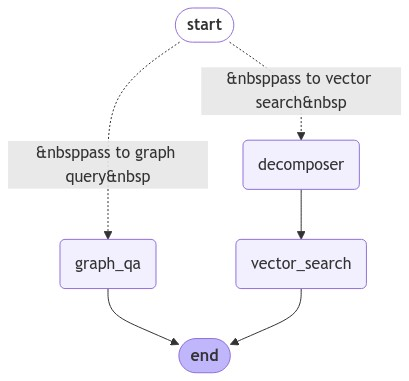

In [177]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

## 與之互動

In [183]:
vector_search_result = app.invoke({"question": "找出類似於密閉空間作業的安全協議"})
vector_search_result

---ROUTE QUESTION---
---ROUTE QUESTION TO VECTOR SEARCH---


> Entering new RetrievalQA chain...

> Finished chain.


{'question': '找出類似於密閉空間作業的安全協議',
 'incidents': [{'id': 'INC009',
   'date': '2024-09-25',
   'severity': '高',
   'description': '大型機械操作不當造成嚴重事故'},
  {'id': 'INC010',
   'date': '2024-10-01',
   'severity': '中',
   'description': '工地車輛碰撞'},
  {'id': 'INC018',
   'date': '2024-11-10',
   'severity': '中',
   'description': '工人吸入有害氣體'}],
 'subqueries': [SubQuery(sub_query='找出類似於密閉空間作業的安全協議'),
  SubQuery(sub_query='執行Neo4j圖形查詢以找出安全協議')]}

In [185]:
vector_search_result.keys()

dict_keys(['question', 'incidents', 'subqueries'])

In [187]:
vector_search_result['incidents']

[{'id': 'INC009',
  'date': '2024-09-25',
  'severity': '高',
  'description': '大型機械操作不當造成嚴重事故'},
 {'id': 'INC010',
  'date': '2024-10-01',
  'severity': '中',
  'description': '工地車輛碰撞'},
 {'id': 'INC018',
  'date': '2024-11-10',
  'severity': '中',
  'description': '工人吸入有害氣體'}]